# Informative distances and summary statistics

Approximate Bayesian computation (ABC) relies on the efficient comparison of relevant features in simulated and observed data, via distance metrics and potentially summary statistics. Separately, methods have been developed to adaptively scale-normalize the distance metric, and to semi-automatically derive informative, low-dimensional summary statistics.

In the notebook on "Adaptive distances" we demonstrated how distances adjusting weights to normalize scales are beneficial for heterogeneous, including outlier-corrupted, data. However, when parts of the data are uninformative, it is desirable to further concentrate the analysis on informative data points. Various methods have been develoepd to capture information of data on parameters in a low-dimensional summary statistics representation, see e.g. [Blum et al. 2013](https://doi.org/10.1214/12-STS406) for a review. A particular approach constructs summary statistics as outputs of regression models of parameters on data, see the seminal work by [Fearnhead and Prangle 2012](https://doi.org/10.1111/j.1467-9868.2011.01010.x). In this notebook, we illustrate the use of regression methods to construct informative summary statistics and sensitivity distance weights in pyABC.

In [1]:
# imports

import numpy as np
import scipy as sp
import tempfile
import matplotlib.pyplot as plt
from functools import partial
import logging
from IPython.display import SVG,display

import pyabc
from pyabc.distance import *
from pyabc.predictor import *
from pyabc.sumstat import *
from pyabc.util import EventIxs, ParTrafo, dict2arrlabels

pyabc.settings.set_figure_params("pyabc")  # for beautified plots

# for debugging
for logger in ["ABC.Distance", "ABC.Predictor", "ABC.Sumstat"]:
    logging.getLogger(logger).setLevel(logging.DEBUG)

## Simple illustration example

To illustrate informativeness of data points, we consider a simple test problem. It consists of a single model output $y_1$ informative of parameter $p_1$, and uninformative model outputs $y_2$.

In [2]:
# problem definition

sigmas = {"p1": 0.1}

def model(p):
    return {"y1": p["p1"] + 1 + sigmas["p1"] * np.random.normal(),
            "y2": 2 + 0.1 * np.random.normal(size=3)}

gt_par = {"p1": 3}

data = {"y1": gt_par["p1"] + 1, "y2": 2 * np.ones(shape=3)}

prior_bounds = {"p1": (0, 10)}

prior = pyabc.Distribution(
    **{
        key: pyabc.RV("uniform", lb, ub - lb)
        for key, (lb, ub) in prior_bounds.items()
    },
)

We employ three approaches to perform inference on this problem.

Firstly, we use a distance adaptively scale-normalizing all statistics by their respective in-sample median absolute deviations (MAD), as introduced in the "Adaptive distances" notebook ("L1+Ada.+MAD").

Secondly, we employ an approach similar to [Fearnhead and Prangle 2012](https://doi.org/10.1111/j.1467-9868.2011.01010.x), using a linear regression model, trained after 40% of the total sample budget, as summary statistic, with a simple L1 distance ("L1+StatLR").

Thirdly, we complement the MAD scale-normalizing weights by sensitivity weights, derived via normalized sensitivities of a linear regression model trained similarly to the second approach. This method thus accounts for informativeness by re-weighting of model outputs, without explicitly employing a low-dimensional summary statistics representation.

In [3]:
# analysis definition

pop_size = 100
total_sims = 3000
fit_sims = 0.4 * total_sims

YPredictor = LinearPredictor
#YPredictor = MLPPredictor

distances = {
    "L1+Ada.+MAD": AdaptivePNormDistance(
        p=1,
        # adaptive scale normalization
        scale_function=mad,
    ),
    "L1+StatLR": PNormDistance(
        p=1,
        # regression-based summary statistics
        sumstat=PredictorSumstat(
            # regression model used
            predictor=YPredictor(),
            # when to fit the regression model
            fit_ixs=EventIxs(sims=fit_sims),
        ),
    ),
    "L1+Ada.+MAD+SensiLR": InfoWeightedPNormDistance(
        p=1,
        # adaptive scale normalization
        scale_function=mad,
        # regression model used to define sensitivity weights
        predictor=YPredictor(),
        # when to fit the regression model
        fit_info_ixs=EventIxs(sims=fit_sims),
    ),
}

colors = {
    distance_id: f"C{i}"
    for i, distance_id in enumerate(distances)
}

ABC.Distance DEBUG: Fit scale ixs: <EventIxs, ts={inf}>
ABC.Sumstat DEBUG: Fit model ixs: <EventIxs, sims=[1200.0]>
ABC.Distance DEBUG: Fit scale ixs: <EventIxs, ts={inf}>
ABC.Distance DEBUG: Fit info ixs: <EventIxs, sims=[1200.0]>


We perform the analysis using all above distance functions and summary statistics. Additionally, below we specify various logging files to capture relevant information for further analysis.

In [4]:
# runs

db_file = tempfile.mkstemp(suffix=".db")[1]

scale_log_file = tempfile.mkstemp()[1]
info_log_file = tempfile.mkstemp()[1]
info_sample_log_file = tempfile.mkstemp()[1]

hs = []
for distance_id, distance in distances.items():
    print(distance_id)
    if isinstance(distance, AdaptivePNormDistance):
        distance.scale_log_file = f"{scale_log_file}_{distance_id}.json"
    if isinstance(distance, InfoWeightedPNormDistance):
        distance.info_log_file = f"{info_log_file}_{distance_id}.json"
        distance.info_sample_log_file = f"{info_sample_log_file}_{distance_id}"

    abc = pyabc.ABCSMC(model, prior, distance, population_size=pop_size)
    h = abc.new(db="sqlite:///" + db_file, observed_sum_stat=data)
    abc.run(max_total_nr_simulations=total_sims)
    hs.append(h)

ABC.Sampler INFO: Parallelize sampling on 4 processes.


L1+Ada.+MAD


ABC.History INFO: Start <ABCSMC id=1, start_time=2021-10-05 16:28:42>
ABC INFO: Calibration sample t = -1.
ABC.Distance DEBUG: Scale weights[0] = {'y1': 5.1134e-01, 'y2:0': 1.5510e+01, 'y2:1': 1.4547e+01, 'y2:2': 1.3475e+01}
ABC.Population INFO: Recording also rejected particles: True
ABC INFO: t: 0, eps: 4.59745998e+00.
ABC INFO: Accepted: 100 / 201 = 4.9751e-01, ESS: 1.0000e+02.
ABC.Distance DEBUG: Scale weights[1] = {'y1': 4.5388e-01, 'y2:0': 1.4813e+01, 'y2:1': 1.4373e+01, 'y2:2': 1.4352e+01}
ABC INFO: t: 1, eps: 3.41090200e+00.
ABC INFO: Accepted: 100 / 284 = 3.5211e-01, ESS: 9.6565e+01.
ABC.Distance DEBUG: Scale weights[2] = {'y1': 5.5646e-01, 'y2:0': 1.5779e+01, 'y2:1': 1.4543e+01, 'y2:2': 1.7292e+01}
ABC INFO: t: 2, eps: 3.04892934e+00.
ABC INFO: Accepted: 100 / 579 = 1.7271e-01, ESS: 9.2805e+01.
ABC.Distance DEBUG: Scale weights[3] = {'y1': 7.1955e-01, 'y2:0': 1.4137e+01, 'y2:1': 1.4302e+01, 'y2:2': 1.4700e+01}
ABC INFO: t: 3, eps: 2.43778707e+00.
ABC INFO: Accepted: 100 / 829

L1+StatLR


ABC.Population INFO: Recording also rejected particles: True
ABC INFO: t: 0, eps: 2.27647885e+00.
ABC INFO: Accepted: 100 / 245 = 4.0816e-01, ESS: 1.0000e+02.
ABC INFO: t: 1, eps: 1.19511989e+00.
ABC INFO: Accepted: 100 / 220 = 4.5455e-01, ESS: 9.9412e+01.
ABC INFO: t: 2, eps: 7.52465584e-01.
ABC INFO: Accepted: 100 / 202 = 4.9505e-01, ESS: 9.9389e+01.
ABC INFO: t: 3, eps: 5.46956010e-01.
ABC INFO: Accepted: 100 / 221 = 4.5249e-01, ESS: 9.8808e+01.
ABC INFO: t: 4, eps: 3.84691343e-01.
ABC INFO: Accepted: 100 / 257 = 3.8911e-01, ESS: 9.5761e+01.
ABC.Predictor INFO: Fitted <LinearPredictor predictor=LinearRegression(normalize=True)> in 0.00s
ABC.Predictor INFO: Pearson correlations: 0.925
ABC.Predictor DEBUG: Linear regression coefficients (n_target, n_feature):
[[ 9.26920586e-01 -4.87631267e-04  1.73335632e-02  3.93242072e-03]]
ABC INFO: t: 5, eps: 3.43475639e-01.
ABC INFO: Accepted: 100 / 360 = 2.7778e-01, ESS: 9.1948e+01.
ABC INFO: t: 6, eps: 1.76790033e-01.
ABC INFO: Accepted: 100 / 

L1+Ada.+MAD+SensiLR


ABC.Distance DEBUG: Scale weights[0] = {'y1': 4.6985e-01, 'y2:0': 1.2223e+01, 'y2:1': 1.1709e+01, 'y2:2': 1.2575e+01}
ABC.Population INFO: Recording also rejected particles: True
ABC.Population INFO: Recording also rejected particles: True
ABC INFO: t: 0, eps: 4.22004334e+00.
ABC INFO: Accepted: 100 / 192 = 5.2083e-01, ESS: 1.0000e+02.
ABC.Distance DEBUG: Scale weights[1] = {'y1': 4.0960e-01, 'y2:0': 1.4857e+01, 'y2:1': 1.5409e+01, 'y2:2': 1.3337e+01}
ABC INFO: t: 1, eps: 3.22773602e+00.
ABC INFO: Accepted: 100 / 345 = 2.8986e-01, ESS: 9.4098e+01.
ABC.Distance DEBUG: Scale weights[2] = {'y1': 5.2532e-01, 'y2:0': 1.3894e+01, 'y2:1': 1.5772e+01, 'y2:2': 1.5956e+01}
ABC INFO: t: 2, eps: 2.75804199e+00.
ABC INFO: Accepted: 100 / 541 = 1.8484e-01, ESS: 8.6741e+01.
ABC.Distance DEBUG: Scale weights[3] = {'y1': 7.0325e-01, 'y2:0': 1.4338e+01, 'y2:1': 1.5559e+01, 'y2:2': 1.6242e+01}
ABC INFO: t: 3, eps: 2.55899508e+00.
ABC INFO: Accepted: 100 / 823 = 1.2151e-01, ESS: 9.6568e+01.
ABC.Distance D

The comparison of the obtained posterior approximations with the true posterior reveals that L1+Ada.+MAD gave a worse fit compared to the other approaches. This is because it only applies scale-normalization, but does not account for informativeness of data, and thus spends a lot of time on fitting $y_2$.

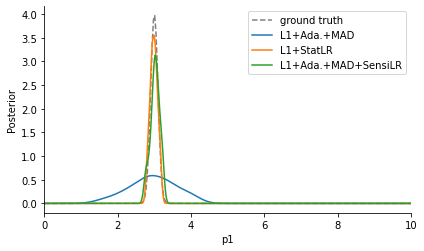

In [5]:
# plot ABC posterior approximations

fig, axes = plt.subplots(ncols=len(prior_bounds), figsize=(6, 4))
if len(prior_bounds) == 1:
    axes = [axes]

# plot ground truth

def unnorm_1d_normal_pdf(p, y_obs, sigma, p_to_y = None):
    """Non-normalized 1-d normal density.
    
    Parameters
    ----------
    p: Parameter to evaluate at.
    y_obs: Observed data.
    sigma: Noise standard deviation.
    p_to_y: Function to deterministically transform p to simulated data.
    
    Returns
    -------
    pd: Probability density/densities at p.
    """
    if p_to_y is None:
        p_to_y = lambda p: p
    y = p_to_y(p)
    pd = np.exp(- (y - y_obs)**2 / (2 * sigma**2))
    return pd

for i_par, par in enumerate(gt_par.keys()):
    # define parameter-simulation transformation
    p_to_y = lambda p: p+1
    # observed data corresponding to parameter
    y_obs = p_to_y(gt_par[par])
    # bounds
    xmin, xmax = prior_bounds[par]
    # standard deviation
    sigma = sigmas[par]

    # pdf as function of only p
    pdf = partial(
        unnorm_1d_normal_pdf, y_obs=y_obs, sigma=sigma, p_to_y=p_to_y,
    )

    # integrate density
    norm = sp.integrate.quad(pdf, xmin, xmax)[0]

    # plot density
    xs = np.linspace(xmin, xmax, 300)
    axes[i_par].plot(
        xs, pdf(xs) / norm, linestyle="dashed",
        color="grey",label="ground truth",
    )

# plot ABC approximations

for i_par, par in enumerate(prior_bounds.keys()):
    for distance_id, h in zip(distances.keys(), hs):
        pyabc.visualization.plot_kde_1d_highlevel(
            h, x=par, xname=par,
            xmin=prior_bounds[par][0], xmax=prior_bounds[par][1],
            ax=axes[i_par], label=distance_id,
            numx=500,
        )

# prettify
for ax in axes[1:]:
    ax.set_ylabel(None)
fig.tight_layout(rect=(0, 0.1, 1, 1))
axes[-1].legend()

Via the log files, we can further examine the employed weights, firstly scale-normalizing weights based on MAD, and secondly sensitivity weights quantifying informativeness. Indeed, while both L1+Ada.+MAD and L1+Ada.+MAD+SensiLR assign large weights to $y_2$, the additional sensitivity weights employed by L1+Ada.+MAD+SensiLR counteract this by assigning a large weight to $y_1$.

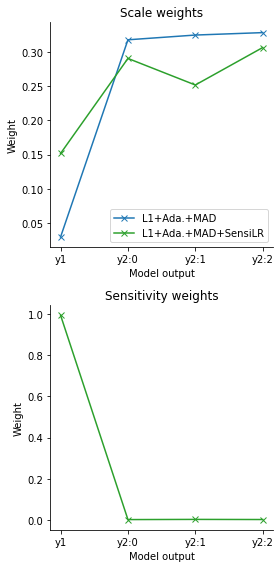

In [6]:
# plot weights

fig, axes = plt.subplots(nrows=2, ncols=len(gt_par), figsize=(4, 8))

# scale weights

scale_distance_ids = [
    distance_id for distance_id in distances.keys()
    if "Ada." in distance_id and "Stat" not in distance_id
]
scale_log_files = []
for i_dist, distance_id in enumerate(scale_distance_ids):
    scale_log_files.append(f"{scale_log_file}_{distance_id}.json")

pyabc.visualization.plot_distance_weights(
    scale_log_files,
    labels=scale_distance_ids,
    colors=[colors[distance_id] for distance_id in scale_distance_ids],
    xlabel="Model output",
    title="Scale weights",
    ax=axes[0],
    keys=dict2arrlabels(data, keys=data.keys()),
)

# info weights

info_distance_ids = [
    distance_id for distance_id in distances.keys()
    if "Sensi" in distance_id
]
info_log_files = []
for i_dist, distance_id in enumerate(info_distance_ids):
    info_log_files.append(f"{info_log_file}_{distance_id}.json")

pyabc.visualization.plot_distance_weights(
    info_log_files,
    labels=info_distance_ids,
    colors=[colors[distance_id] for distance_id in info_distance_ids],
    xlabel="Model output",
    title="Sensitivity weights",
    ax=axes[1],
    keys=dict2arrlabels(data, keys=data.keys()),
)

fig.tight_layout()

To further understand the employed sensitivity matrix, we can visualize the connections between model outputs and parameters (in this case a single one) via a "Sankey" flow diagram. In this case, this gives no further information beyond the above weight diagram.

ABC.Predictor INFO: Fitted <LinearPredictor predictor=LinearRegression(normalize=True)> in 0.00s
ABC.Predictor INFO: Pearson correlations: 0.998
ABC.Predictor DEBUG: Linear regression coefficients (n_target, n_feature):
[[ 0.9973475  -0.00155596  0.00246926  0.00186498]]
ABC.Distance DEBUG: Optimal FD delta: [0.1  0.01 0.1  0.1 ]


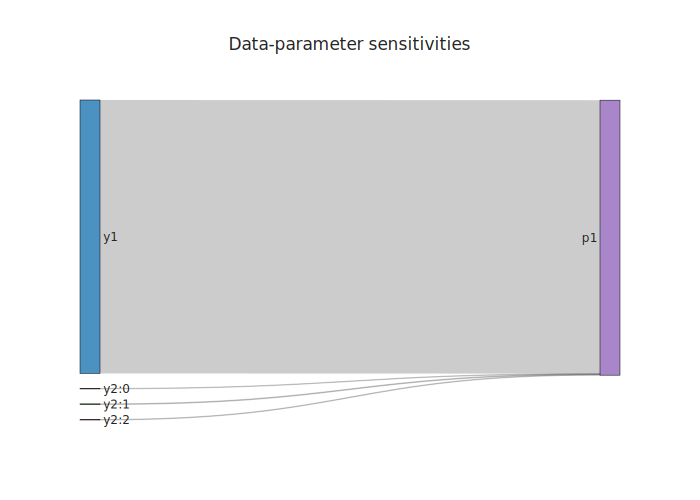

In [7]:
# plot flow diagram

fig = pyabc.visualization.plot_sensitivity_sankey(
    info_sample_log_file=f"{info_sample_log_file}_L1+Ada.+MAD+SensiLR",
    t=f"{info_log_file}_L1+Ada.+MAD+SensiLR.json",
    h=hs[-1],
    predictor=LinearPredictor(),
)

# here just showing a non-interactive plot to reduce storage
img_file = tempfile.mkstemp(suffix=(".svg"))[1]
fig.write_image(img_file)
display(SVG(img_file))

## Challenging problem features

Now, we turn to a slightly more challenging problem:

* $y_1\sim\mathcal{N}(\theta_1,0.1^2)$ is informative of $\theta_1$, with a relatively wide corresponding prior $\theta_1\sim U[-7, 7]$,
* $y_2\sim\mathcal{N}(\theta_2,100^2)$ is informative of $\theta_2$, with corresponding prior $\theta_2\sim U[-700, 700]$,
* $y_3\sim\mathcal{N}(\theta_3, 4 \cdot 100^2)^{\otimes 4}$ is a four-dimensional vector informative of $\theta_3$, with corresponding prior $\theta_3\sim U[-700, 700]$,
* $y_4\sim\mathcal{N}(\theta_4^2, 0.1^2)$ is informative of $\theta_4$, with corresponding symmetric prior $\theta_4\sim U[-1, 1]$, however is quadratic in the parameter, resulting in a bimodal posterior distribution for $y_{\text{obs},4}\neq 0$,
* $y_5\sim\mathcal{N}(0, 10)^{\otimes 10}$ is an uninformative 10-dimensional vector.

The problem encompasses multiple challenging features established methods have problems with:

* A substantial part of the data, $y_5$, is uninformative, such that approaches not accounting for informativeness of data may converge slower.
* Both data and parameters are on different scales, such that approaches comparing data, or, via regression-based summary statistics, parameters, without normalization may be biased towards large-scale variables. Further, e.g. the prior of $\theta_1$ is relatively wide, such that pre-calibrated weighting is sub-optimal, as discussed in \citet{Prangle2017}.
* $y_4$ is quadratic in $\theta_4$ and symmetric over the prior, such that the inverse first-order regression approaches as in FearnheadPra2012} cannot capture a meaningful relationship.
* While the distributions of $y_3$ and $y_4$ are such that the posterior distributions of $\theta_3$, $\theta_4$ are identical, in solely scale-normalized approaches such as [Fearnhead and Prangle 2012](https://doi.org/10.1111/j.1467-9868.2011.01010.x), the impact of $y_4$ on the distance value is roughly four times as high as that of $y_3$, leading to potentially uneven convergence.

In [8]:
# problem definition

sigmas = {"p1": 1e-1, "p2": 1e2, "p3": 1e2, "p4": 1e-1}

def model(p):
    return {
        "y1": p["p1"] + sigmas["p1"] * np.random.normal(),
        "y2": p["p2"] + sigmas["p2"] * np.random.normal(),
        "y3": p["p3"] + np.sqrt(4 * sigmas["p3"]**2) * np.random.normal(size=4),
        "y4": p["p4"] ** 2 + sigmas["p4"] * np.random.normal(),
        "y5": 1e1 * np.random.normal(size=10),
    }

prior_bounds = {
    "p1": (-7e0, 7e0),
    "p2": (-7e2, 7e2),
    "p3": (-7e2, 7e2),
    "p4": (-1e0, 1e0),
}

prior = pyabc.Distribution(
    **{
        key: pyabc.RV("uniform", lb, ub - lb)
        for key, (lb, ub) in prior_bounds.items()
    },
)

gt_par = {"p1": 0, "p2": 0, "p3": 0, "p4": 0.5}
data = {"y1": 0, "y2": 0, "y3": 0 * np.ones(4), "y4": 0.5**2, "y5": 0 * np.ones(10)}

To tackle these problems, we suggest to firstly consistenly employ scale normalization, both on the raw model outputs and on the level of summary statistics. Secondly, we suggest to instead of only inferring a mapping $s: y \mapsto \theta$, we target augmented parameter vectors, $s: y \mapsto \lambda(\theta)$, with e.g. $\lambda(\theta) = (\theta^1,\ldots,\theta^4)$. This practically allows to break symmetry, e.g. if only $\theta^2$ can be expressed as a function of the data. Conceptually, this further allows to obtain a more accurate description of the posterior distribution, as the summary statistics may be regarded as approximations to $s(y) = \mathbb{E}[\lambda(\theta)|y]$, using which as summary statistics preserves the corresponding posterior moments, i.e.

$$\lim_{\varepsilon\rightarrow 0}\mathbb{E}_{\pi_{\text{ABC},\varepsilon}}[\lambda(\Theta)|s(y_\text{obs})] = \mathbb{E}[\lambda(\Theta)|Y=y_\text{obs}].$$

Methods employing scale normalization, accounting for informativeness, and augmented regression targets, are L1+Ada.+MAD+StatLR+P4, which uses regression-based summary statistics, and L1+Ada.+MAD+SensiLR+P4, which uses sensitivity weights.
For comparison, we consider L1+Ada.+MAD only normalizing scales, and L1+StatLR, using non-scale normaled summary statistics, as well as L1+Ada.+MAD+StatLR and L1+Ada.+MAD+SensiLR using only a subset of methods.

In [9]:
# analysis definition

pop_size = 1000
total_sims = 50000
par_trafos = [lambda x: x, lambda x: x**2, lambda x: x**3, lambda x: x**4]
fit_sims = 0.4 * total_sims

YPredictor = LinearPredictor
#YPredictor = MLPPredictor

distances = {
    "L1+Ada.+MAD": AdaptivePNormDistance(
        p=1,
        scale_function=mad,
    ),
    "L1+StatLR": PNormDistance(
        p=1,
        sumstat=PredictorSumstat(
            predictor=YPredictor(normalize_features=False, normalize_labels=False),
            fit_ixs=EventIxs(sims=fit_sims),
        ),
    ),
    "L1+Ada.+MAD+StatLR": AdaptivePNormDistance(
        p=1,
        scale_function=mad,
        sumstat=PredictorSumstat(
            predictor=YPredictor(),
            fit_ixs=EventIxs(sims=fit_sims),
        ),
    ),
    "L1+Ada.+MAD+StatLR+P4": AdaptivePNormDistance(
        p=1,
        scale_function=mad,
        sumstat=PredictorSumstat(
            predictor=YPredictor(),
            fit_ixs=EventIxs(sims=fit_sims),
            par_trafo=ParTrafo(trafos=par_trafos),
        ),
    ),
    "L1+Ada.+MAD+SensiLR": InfoWeightedPNormDistance(
        p=1,
        scale_function=mad,
        predictor=YPredictor(),
        fit_info_ixs=EventIxs(sims=fit_sims),
        feature_normalization="mad",
    ),
    "L1+Ada.+MAD+SensiLR+P4": InfoWeightedPNormDistance(
        p=1,
        scale_function=mad,
        predictor=YPredictor(),
        fit_info_ixs=EventIxs(sims=fit_sims),
        feature_normalization="mad",
        par_trafo=ParTrafo(trafos=par_trafos),
    ),
}

colors = {
    distance_id: f"C{i}"
    for i, distance_id in enumerate(distances)
}

ABC.Distance DEBUG: Fit scale ixs: <EventIxs, ts={inf}>
ABC.Sumstat DEBUG: Fit model ixs: <EventIxs, sims=[20000.0]>
ABC.Sumstat DEBUG: Fit model ixs: <EventIxs, sims=[20000.0]>
ABC.Distance DEBUG: Fit scale ixs: <EventIxs, ts={inf}>
ABC.Sumstat DEBUG: Fit model ixs: <EventIxs, sims=[20000.0]>
ABC.Distance DEBUG: Fit scale ixs: <EventIxs, ts={inf}>
ABC.Distance DEBUG: Fit scale ixs: <EventIxs, ts={inf}>
ABC.Distance DEBUG: Fit info ixs: <EventIxs, sims=[20000.0]>
ABC.Distance DEBUG: Fit scale ixs: <EventIxs, ts={inf}>
ABC.Distance DEBUG: Fit info ixs: <EventIxs, sims=[20000.0]>


For the analysis, we suggest the use of sufficiently large population sizes, as the process model is more complex.

In [10]:
%%time

# runs

db_file = tempfile.mkstemp(suffix=".db")[1]

scale_log_file = tempfile.mkstemp()[1]
info_log_file = tempfile.mkstemp()[1]
info_sample_log_file = tempfile.mkstemp()[1]

hs = []
for distance_id, distance in distances.items():
    print(distance_id)
    if isinstance(distance, AdaptivePNormDistance):
        distance.scale_log_file = f"{scale_log_file}_{distance_id}.json"
    if isinstance(distance, InfoWeightedPNormDistance):
        distance.info_log_file = f"{info_log_file}_{distance_id}.json"
        distance.info_sample_log_file = f"{info_sample_log_file}_{distance_id}"

    abc = pyabc.ABCSMC(model, prior, distance, population_size=pop_size)
    h = abc.new(db="sqlite:///" + db_file, observed_sum_stat=data)
    abc.run(max_total_nr_simulations=total_sims)
    hs.append(h)

ABC.Sampler INFO: Parallelize sampling on 4 processes.
ABC.History INFO: Start <ABCSMC id=1, start_time=2021-10-05 16:29:00>
ABC INFO: Calibration sample t = -1.


L1+Ada.+MAD


ABC.Distance DEBUG: Scale weights[0] = {'y1': 2.8851e-01, 'y2': 2.7844e-03, 'y3:0': 2.6532e-03, 'y3:1': 2.8382e-03, 'y3:2': 2.6794e-03, 'y3:3': 2.7390e-03, 'y4': 4.2668e+00, 'y5:0': 1.4627e-01, 'y5:1': 1.4300e-01, 'y5:2': 1.4622e-01, 'y5:3': 1.5646e-01, 'y5:4': 1.4528e-01, 'y5:5': 1.5690e-01, 'y5:6': 1.5268e-01, 'y5:7': 1.5360e-01, 'y5:8': 1.4845e-01, 'y5:9': 1.5199e-01}
ABC.Population INFO: Recording also rejected particles: True
ABC INFO: t: 0, eps: 1.92967526e+01.
ABC INFO: Accepted: 1000 / 1910 = 5.2356e-01, ESS: 1.0000e+03.
ABC.Distance DEBUG: Scale weights[1] = {'y1': 2.9052e-01, 'y2': 2.9597e-03, 'y3:0': 2.7794e-03, 'y3:1': 2.8087e-03, 'y3:2': 2.8266e-03, 'y3:3': 2.8147e-03, 'y4': 4.4770e+00, 'y5:0': 1.6340e-01, 'y5:1': 1.4413e-01, 'y5:2': 1.4626e-01, 'y5:3': 1.4393e-01, 'y5:4': 1.4491e-01, 'y5:5': 1.4534e-01, 'y5:6': 1.4699e-01, 'y5:7': 1.4748e-01, 'y5:8': 1.4862e-01, 'y5:9': 1.4782e-01}
ABC INFO: t: 1, eps: 1.69425338e+01.
ABC INFO: Accepted: 1000 / 2639 = 3.7893e-01, ESS: 8.0

L1+StatLR


ABC.Population INFO: Recording also rejected particles: True
ABC INFO: t: 0, eps: 1.90447149e+03.
ABC INFO: Accepted: 1000 / 1993 = 5.0176e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 1.33054848e+03.
ABC INFO: Accepted: 1000 / 2119 = 4.7192e-01, ESS: 8.5306e+02.
ABC INFO: t: 2, eps: 1.05253310e+03.
ABC INFO: Accepted: 1000 / 2833 = 3.5298e-01, ESS: 6.9809e+02.
ABC INFO: t: 3, eps: 8.82249032e+02.
ABC INFO: Accepted: 1000 / 3817 = 2.6199e-01, ESS: 3.8907e+02.
ABC INFO: t: 4, eps: 7.60987552e+02.
ABC INFO: Accepted: 1000 / 5649 = 1.7702e-01, ESS: 3.8403e+02.
ABC INFO: t: 5, eps: 6.51226211e+02.
ABC INFO: Accepted: 1000 / 8629 = 1.1589e-01, ESS: 4.2228e+02.
ABC.Predictor INFO: Fitted <LinearPredictor predictor=LinearRegression(normalize=True) normalize_features=False normalize_labels=False> in 0.01s
ABC.Predictor INFO: Pearson correlations: 1.000 0.902 0.846 0.119
ABC.Predictor DEBUG: Linear regression coefficients (n_target, n_feature):
[[ 9.99680229e-01  7.49670264e-06  9.96302897e-06  2.

L1+Ada.+MAD+StatLR


ABC.Distance DEBUG: Scale weights[0] = {'y1': 2.8977e-01, 'y2': 2.8718e-03, 'y3:0': 2.8727e-03, 'y3:1': 2.8415e-03, 'y3:2': 2.7911e-03, 'y3:3': 2.8908e-03, 'y4': 4.5701e+00, 'y5:0': 1.4108e-01, 'y5:1': 1.4494e-01, 'y5:2': 1.4367e-01, 'y5:3': 1.6047e-01, 'y5:4': 1.5288e-01, 'y5:5': 1.4790e-01, 'y5:6': 1.4805e-01, 'y5:7': 1.4474e-01, 'y5:8': 1.4130e-01, 'y5:9': 1.4169e-01}
ABC.Population INFO: Recording also rejected particles: True
ABC.Population INFO: Recording also rejected particles: True
ABC INFO: t: 0, eps: 1.90757691e+01.
ABC INFO: Accepted: 1000 / 2070 = 4.8309e-01, ESS: 1.0000e+03.
ABC.Distance DEBUG: Scale weights[1] = {'y1': 2.8878e-01, 'y2': 2.7860e-03, 'y3:0': 2.8598e-03, 'y3:1': 2.8235e-03, 'y3:2': 2.7717e-03, 'y3:3': 2.8305e-03, 'y4': 4.6354e+00, 'y5:0': 1.4492e-01, 'y5:1': 1.4532e-01, 'y5:2': 1.4374e-01, 'y5:3': 1.5024e-01, 'y5:4': 1.4798e-01, 'y5:5': 1.5130e-01, 'y5:6': 1.5529e-01, 'y5:7': 1.4869e-01, 'y5:8': 1.4251e-01, 'y5:9': 1.4292e-01}
ABC INFO: t: 1, eps: 1.6649666

L1+Ada.+MAD+StatLR+P4


ABC.Distance DEBUG: Scale weights[0] = {'y1': 3.0842e-01, 'y2': 2.8634e-03, 'y3:0': 2.8003e-03, 'y3:1': 2.7398e-03, 'y3:2': 2.7468e-03, 'y3:3': 2.9446e-03, 'y4': 4.4356e+00, 'y5:0': 1.5740e-01, 'y5:1': 1.4629e-01, 'y5:2': 1.5039e-01, 'y5:3': 1.4953e-01, 'y5:4': 1.6140e-01, 'y5:5': 1.4718e-01, 'y5:6': 1.4476e-01, 'y5:7': 1.5662e-01, 'y5:8': 1.3944e-01, 'y5:9': 1.5207e-01}
ABC.Population INFO: Recording also rejected particles: True
ABC.Population INFO: Recording also rejected particles: True
ABC INFO: t: 0, eps: 1.90952933e+01.
ABC INFO: Accepted: 1000 / 2154 = 4.6425e-01, ESS: 1.0000e+03.
ABC.Distance DEBUG: Scale weights[1] = {'y1': 2.8647e-01, 'y2': 2.8534e-03, 'y3:0': 2.9234e-03, 'y3:1': 2.8012e-03, 'y3:2': 2.8092e-03, 'y3:3': 2.7833e-03, 'y4': 4.4927e+00, 'y5:0': 1.4757e-01, 'y5:1': 1.4770e-01, 'y5:2': 1.4766e-01, 'y5:3': 1.4461e-01, 'y5:4': 1.4371e-01, 'y5:5': 1.4664e-01, 'y5:6': 1.5462e-01, 'y5:7': 1.4839e-01, 'y5:8': 1.4697e-01, 'y5:9': 1.5267e-01}
ABC INFO: t: 1, eps: 1.6508691

L1+Ada.+MAD+SensiLR


ABC.Distance DEBUG: Scale weights[0] = {'y1': 2.6821e-01, 'y2': 3.1293e-03, 'y3:0': 2.8105e-03, 'y3:1': 2.9484e-03, 'y3:2': 2.8090e-03, 'y3:3': 2.9210e-03, 'y4': 4.5209e+00, 'y5:0': 1.4179e-01, 'y5:1': 1.5730e-01, 'y5:2': 1.4348e-01, 'y5:3': 1.5357e-01, 'y5:4': 1.5022e-01, 'y5:5': 1.4413e-01, 'y5:6': 1.4824e-01, 'y5:7': 1.4265e-01, 'y5:8': 1.5048e-01, 'y5:9': 1.4781e-01}
ABC.Population INFO: Recording also rejected particles: True
ABC.Population INFO: Recording also rejected particles: True
ABC INFO: t: 0, eps: 1.90944100e+01.
ABC INFO: Accepted: 1000 / 1979 = 5.0531e-01, ESS: 1.0000e+03.
ABC.Distance DEBUG: Scale weights[1] = {'y1': 2.7525e-01, 'y2': 2.8392e-03, 'y3:0': 2.9681e-03, 'y3:1': 2.8163e-03, 'y3:2': 2.8808e-03, 'y3:3': 2.8431e-03, 'y4': 4.6331e+00, 'y5:0': 1.5114e-01, 'y5:1': 1.5244e-01, 'y5:2': 1.5372e-01, 'y5:3': 1.4385e-01, 'y5:4': 1.4904e-01, 'y5:5': 1.4895e-01, 'y5:6': 1.4779e-01, 'y5:7': 1.5019e-01, 'y5:8': 1.5084e-01, 'y5:9': 1.5249e-01}
ABC INFO: t: 1, eps: 1.6713630

L1+Ada.+MAD+SensiLR+P4


ABC.Distance DEBUG: Scale weights[0] = {'y1': 2.8525e-01, 'y2': 2.8646e-03, 'y3:0': 2.8032e-03, 'y3:1': 2.8385e-03, 'y3:2': 3.0012e-03, 'y3:3': 3.0270e-03, 'y4': 4.6763e+00, 'y5:0': 1.5566e-01, 'y5:1': 1.4717e-01, 'y5:2': 1.4941e-01, 'y5:3': 1.4298e-01, 'y5:4': 1.4547e-01, 'y5:5': 1.5924e-01, 'y5:6': 1.4698e-01, 'y5:7': 1.4132e-01, 'y5:8': 1.4609e-01, 'y5:9': 1.4198e-01}
ABC.Population INFO: Recording also rejected particles: True
ABC.Population INFO: Recording also rejected particles: True
ABC INFO: t: 0, eps: 1.93329509e+01.
ABC INFO: Accepted: 1000 / 1967 = 5.0839e-01, ESS: 1.0000e+03.
ABC.Distance DEBUG: Scale weights[1] = {'y1': 2.7936e-01, 'y2': 2.8938e-03, 'y3:0': 2.8957e-03, 'y3:1': 2.8658e-03, 'y3:2': 2.8803e-03, 'y3:3': 2.8448e-03, 'y4': 4.6994e+00, 'y5:0': 1.5409e-01, 'y5:1': 1.4606e-01, 'y5:2': 1.5135e-01, 'y5:3': 1.5049e-01, 'y5:4': 1.4668e-01, 'y5:5': 1.5159e-01, 'y5:6': 1.4987e-01, 'y5:7': 1.5146e-01, 'y5:8': 1.4902e-01, 'y5:9': 1.5076e-01}
ABC INFO: t: 1, eps: 1.6753877

CPU times: user 3min 30s, sys: 15.1 s, total: 3min 45s
Wall time: 8min 54s


While overall all approaches would benefit from a continued analysis, the approaches L1+Ada.+MAD+StatLR+P4 and L1+Ada.+MAD+SensiLR+P4 employing scale normalization, accounting for informativeness, and using augmented regression targets, approximate the true posterior distribution best.
Using only scale normalization captures the overall dynamics, however givese large uncertainties, as unnecessary emphasis is put on $y_5$.
Approaches only using $\theta$ as regression targets however fail to capture the dynamics of $\theta_4$, as the regression model cannot unravel a meaningful relationship between data and parameters.

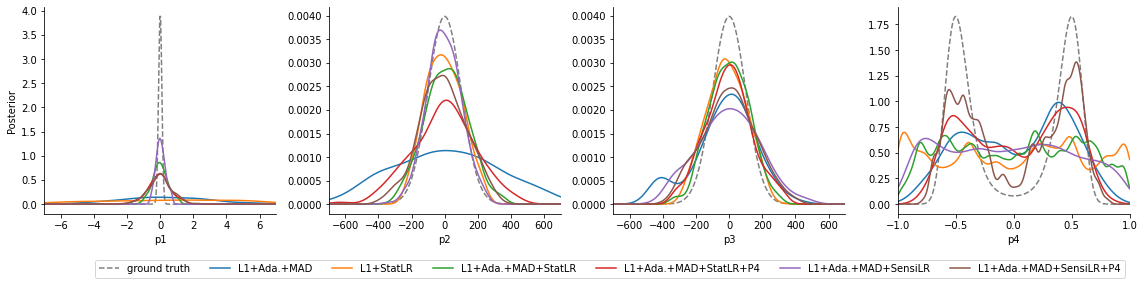

In [11]:
fig, axes = plt.subplots(ncols=len(prior_bounds), figsize=(16, 4))

# plot ground truth

for i_par, par in enumerate(gt_par.keys()):
    # define parameter-simulation transformation
    p_to_y = lambda p: p
    if par == "p4":
        p_to_y = lambda p: p**2
    # observed data corresponding to parameter
    y_obs = p_to_y(gt_par[par])
    # bounds
    xmin, xmax = prior_bounds[par]
    # standard deviation
    sigma = sigmas[par]

    # pdf as function of only p
    pdf = partial(
        unnorm_1d_normal_pdf, y_obs=y_obs, sigma=sigma, p_to_y=p_to_y,
    )

    # integrate density
    norm = sp.integrate.quad(pdf, xmin, xmax)[0]

    # plot density
    xs = np.linspace(xmin, xmax, 300)
    axes[i_par].plot(
        xs, pdf(xs) / norm, linestyle="dashed",
        color="grey",label="ground truth",
    )

# plot ABC approximations

for i_par, par in enumerate(prior_bounds.keys()):
    for distance_id, h in zip(distances.keys(), hs):
        pyabc.visualization.plot_kde_1d_highlevel(
            h, x=par, xname=par,
            xmin=prior_bounds[par][0], xmax=prior_bounds[par][1],
            ax=axes[i_par], label=distance_id,
            kde=pyabc.GridSearchCV() if par == "p4" else None,
            numx=500,
        )

# prettify
for ax in axes[1:]:
    ax.set_ylabel(None)
fig.tight_layout(rect=(0, 0.1, 1, 1))
axes[-1].legend(bbox_to_anchor=(1, -0.2), loc="upper right", ncol=len(distances)+1)

While the scale weights accurately depict the scales the various model output types vary on, the sensitivity weights are high for $y_1$ through $y_4$, with low weights assigned to $y_5$. Very roughly, the sum of sensitivity weights for the four model outputs $y_3$ is roughly equal to e.g. the sensitivity weigh assigned to $y_2$, as desirable. However, the weights assigned are now completely homogeneous, indicating that an increased training sample or more complex regression model may be preferable.

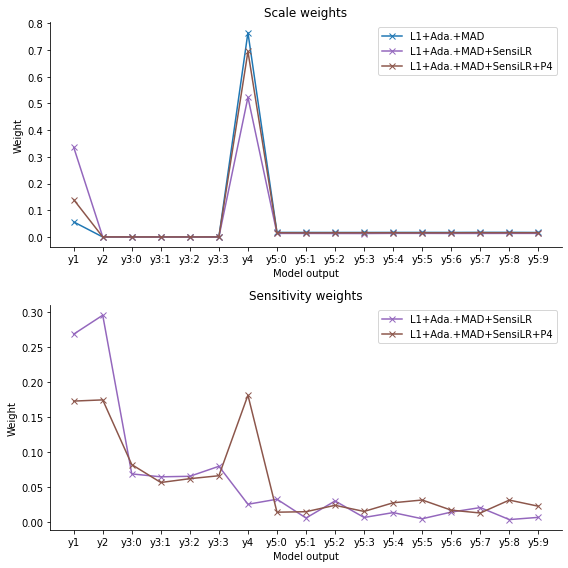

In [12]:
# plot weights

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))

# scale weights

scale_distance_ids = [
    distance_id for distance_id in distances.keys()
    if "Ada." in distance_id and "Stat" not in distance_id
]
scale_log_files = []
for i_dist, distance_id in enumerate(scale_distance_ids):
    scale_log_files.append(f"{scale_log_file}_{distance_id}.json")

pyabc.visualization.plot_distance_weights(
    scale_log_files,
    labels=scale_distance_ids,
    colors=[colors[distance_id] for distance_id in scale_distance_ids],
    xlabel="Model output",
    title="Scale weights",
    ax=axes[0],
    keys=dict2arrlabels(data, keys=data.keys()),
)

# info weights

info_distance_ids = [
    distance_id for distance_id in distances.keys()
    if "Sensi" in distance_id
]
info_log_files = []
for i_dist, distance_id in enumerate(info_distance_ids):
    info_log_files.append(f"{info_log_file}_{distance_id}.json")

pyabc.visualization.plot_distance_weights(
    info_log_files,
    labels=info_distance_ids,
    colors=[colors[distance_id] for distance_id in info_distance_ids],
    xlabel="Model output",
    title="Sensitivity weights",
    ax=axes[1],
    keys=dict2arrlabels(data, keys=data.keys()),
)

fig.tight_layout()

ABC.Predictor INFO: Fitted <LinearPredictor predictor=LinearRegression(normalize=True)> in 0.02s
INFO:ABC.Predictor:Fitted <LinearPredictor predictor=LinearRegression(normalize=True)> in 0.02s
ABC.Predictor INFO: Pearson correlations: 0.999 0.957 0.898 0.062 0.060 0.038 0.084 0.924 0.872 0.846 0.700 0.065 0.057 0.033 0.138 0.873
INFO:ABC.Predictor:Pearson correlations: 0.999 0.957 0.898 0.062 0.060 0.038 0.084 0.924 0.872 0.846 0.700 0.065 0.057 0.033 0.138 0.873
ABC.Predictor DEBUG: Linear regression coefficients (n_target, n_feature):
[[ 9.99478273e-01  1.23334087e-04  9.08956645e-04  2.80726650e-04
  -9.60275067e-04 -3.22973195e-04  4.78441547e-04 -2.10082976e-04
  -4.28321421e-05  4.45123189e-05  2.16048985e-04 -4.48089088e-06
   4.03655594e-04  8.76707664e-06 -2.20078258e-04  6.17578463e-04
   3.17453959e-04]
 [-1.10541794e-03  9.57337471e-01 -1.30716855e-03  3.19681099e-04
   6.02590935e-04 -1.06700211e-03  1.57700210e-03  3.25548552e-03
   1.80188150e-04 -2.20938301e-03 -2.21323

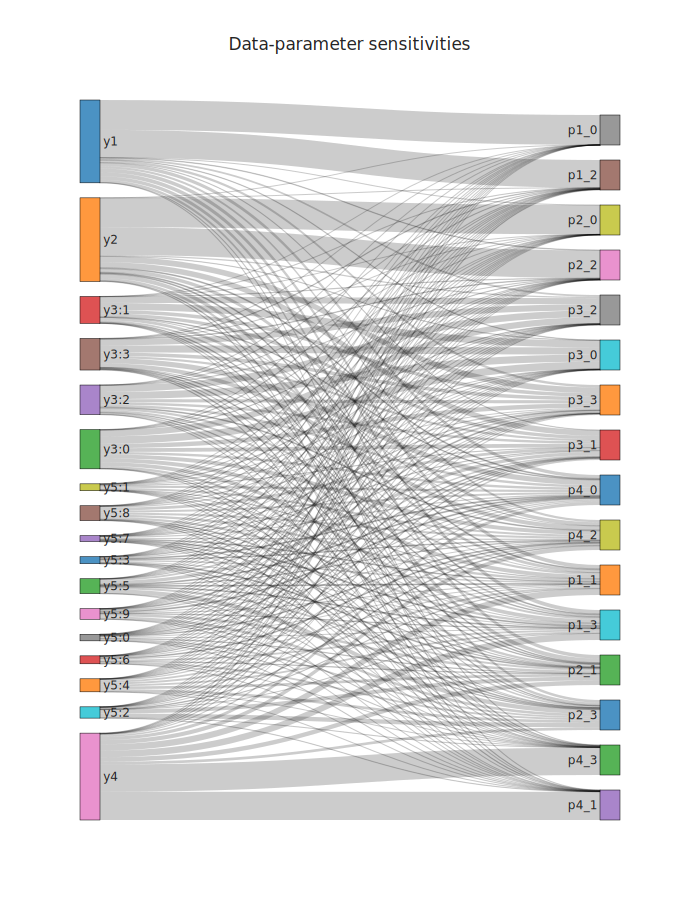

In [13]:
# plot flow diagram

fig = pyabc.visualization.plot_sensitivity_sankey(
    info_sample_log_file=f"{info_sample_log_file}_L1+Ada.+MAD+SensiLR+P4",
    t=f"{info_log_file}_L1+Ada.+MAD+SensiLR+P4.json",
    h=hs[-1],
    predictor=LinearPredictor(),
    par_trafo=ParTrafo(trafos=par_trafos),
    height=900,
)

# here just showing a non-interactive plot to reduce storage
img_file = tempfile.mkstemp(suffix=(".svg"))[1]
fig.write_image(img_file)
display(SVG(img_file))